# Import Necessary Libraries

- This cell imports essential libraries for data analysis, visualization, and machine learning.
- Includes:
  - **Data processing**: `pandas`, `numpy`
  - **Visualization**: `matplotlib.pyplot`, `seaborn`
  - **Preprocessing**: `StandardScaler`, `SMOTE` (oversampling for imbalanced datasets)
  - **Model Evaluation**: Custom utility function `evaluate_models`
  - **Machine Learning Models**: RandomForest, AdaBoost, GradientBoost, XGBoost, Naive Bayes, Decision Tree
  - **PCA** for dimensionality reduction
- Warnings are suppressed for a cleaner output.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from featuer_extraction import extract_features_from_info
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from utils import  evaluate_models

from sklearn.ensemble import (RandomForestClassifier, 
                               AdaBoostClassifier, 
                               GradientBoostingClassifier)
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

# Load Dataset
- Reads the data file (`ECU_IoHT.xlsx`) into a Pandas DataFrame named `data`.
- Ensures the data is ready for subsequent analysis.

In [2]:
path_to_data = 'data/ECU_IoHT.xlsx'
data = pd.read_excel(path_to_data)

## Protocol vs Type Visualization

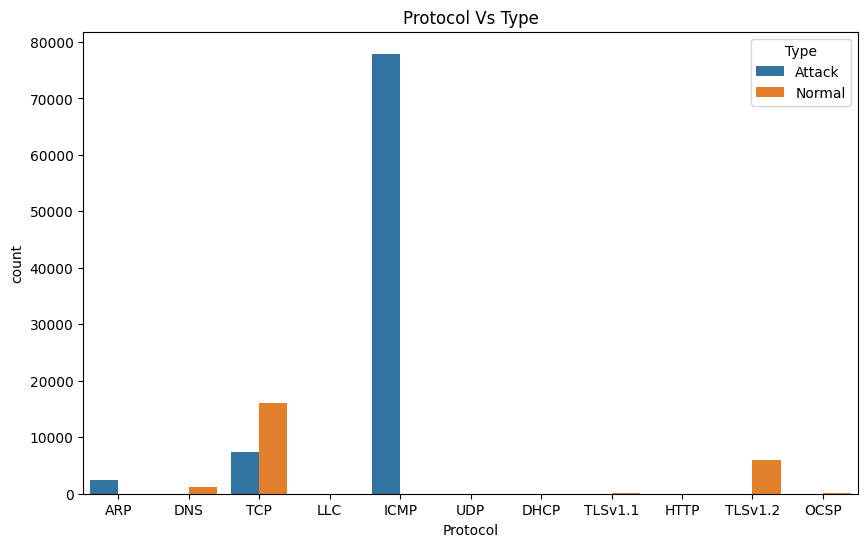

In [3]:
columns_to_plot = [
    'Protocol', ]

for column in columns_to_plot:
    plt.figure(figsize=(10,6))
    sns.countplot(x=column, hue='Type', data= data)
    plt.title(f'{column} Vs Type')
    plt.show()

- **Objective**: To understand the distribution of the target variable (`Type`) across different `Protocol` categories.
- **Plot Details**:
  - A count plot visualizes the relationship between `Protocol` and `Type`.
  - **Observation**: The `TCP` protocol is the only one containing both attack and normal data, indicating its significance for classification tasks.



### Filter Data for `TCP` Protocol
- Extracts rows where the `Protocol` column equals `'TCP'`.
- Prints the shape of the resulting DataFrame (`tcp_rows`), showing 23,494 rows and 9 columns.


In [4]:
# Extract rows where protocol == 'TCP'
tcp_rows = data[data['Protocol'] == 'TCP']
tcp_rows.shape

(23494, 9)

### Display Filtered `TCP` Rows
- Displays the first few rows of the `tcp_rows` DataFrame for inspection.


In [5]:
tcp_rows.head()

,No.,Time,Source,Destination,Protocol,Length,Info,Type,Type of attack
6,7,0.433064,192.168.43.186,192.168.43.1,TCP,58,36954 > 1720 [SYN] Seq=0 Win=1024 Len=0 MSS=...,Normal,No Attack
7,8,0.433084,192.168.43.186,192.168.43.1,TCP,58,36954 > 5900 [SYN] Seq=0 Win=1024 Len=0 MSS=...,Normal,No Attack
8,9,0.433089,192.168.43.186,192.168.43.1,TCP,58,36954 > 135 [SYN] Seq=0 Win=1024 Len=0 MSS=1460,Normal,No Attack
9,10,0.433092,192.168.43.186,192.168.43.1,TCP,58,36954 > 143 [SYN] Seq=0 Win=1024 Len=0 MSS=1460,Normal,No Attack
10,11,0.433096,192.168.43.186,192.168.43.1,TCP,58,36954 > 993 [SYN] Seq=0 Win=1024 Len=0 MSS=1460,Normal,No Attack


# Feature Extraction
- **Purpose**: Extracts additional features from the `Info` column of the `tcp_rows` DataFrame using the `extract_features_from_info` function.

In [6]:
tcp_df = extract_features_from_info(tcp_rows)
tcp_df.shape

(23494, 28)

- Original columns: 9
- Expanded columns after extraction: 28
The function identifies and extracts relevant headers/features for TCP protocol data analysis.

# Data Summary
- **Purpose**: Displays an overview of the DataFrame structure and missing values for each feature.

In [7]:
tcp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 6 to 111201
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   No.               23494 non-null  int64  
 1   Time              23494 non-null  float64
 2   Source            23494 non-null  object 
 3   Destination       23494 non-null  object 
 4   Protocol          23494 non-null  object 
 5   Length            23494 non-null  int64  
 6   Info              23494 non-null  object 
 7   Type              23494 non-null  object 
 8   Type of attack    23494 non-null  object 
 9   source_port       23494 non-null  int64  
 10  destination_port  23494 non-null  int64  
 11  seq               23494 non-null  int64  
 12  transaction_id    0 non-null      float64
 13  length            23494 non-null  int64  
 14  win               23494 non-null  int64  
 15  mss               8097 non-null   float64
 16  ack               14476 non-null  float64
 1

- **Key Insights**:
  - Some features have a large number of missing values (e.g., `transaction_id`, `ws`, `urg`, `ttl`, etc.).
  - Certain features like `length` and `win` are complete (no missing values).
  - Columns such as `ttl`, `who_has_ip`, and `tell_ip` are entirely null (`0 non-null`).

## Identify Features with Excessive Null Values
- **Objective**: Identifies features with more than 90% missing values (threshold ≤ 1000 non-null entries).

In [11]:
cols_not_null_inferior1000 = tcp_df.loc[:,tcp_df.notna().sum() <= 1000].columns
print('Showing the % of NULL values in those columns.')
tcp_df[cols_not_null_inferior1000].isnull().sum()/len(tcp_df)

Showing the % of NULL values in those columns.


transaction_id    1.000000
ws                0.982889
urg               0.999617
sack_perm         0.982889
ttl               1.000000
seq_ack           0.991104
ack_num           0.991104
who_has_ip        1.000000
tell_ip           1.000000
dtype: float64

- **Columns Identified**:
  - `transaction_id`, `ws`, `urg`, `sack_perm`, `ttl`, `seq_ack`, `ack_num`, `who_has_ip`, `tell_ip`
- Percentage of null values in these columns, confirming they are almost entirely empty.

## Drop Columns with Excessive Null Values
- **Purpose**: Removes features identified in Cell 8 due to their high percentage of missing values.
- **Before**: 28 columns
- **After**: 19 columns
- **Reason**: Dropping these columns reduces noise and simplifies the dataset while preserving valuable information.

In [10]:
print('shape of data frame before droping the columns: ', tcp_df.shape)
tcp_df = tcp_df.drop(cols_not_null_inferior1000, axis=1)
print('shape of data frame after droping the columns: ', tcp_df.shape)

shape of data frame before droping the columns:  (23494, 28)
shape of data frame after droping the columns:  (23494, 19)


In [11]:
tcp_df[tcp_df.columns.to_list()].isnull().sum()

No.                     0
Time                    0
Source                  0
Destination             0
Protocol                0
Length                  0
Info                    0
Type                    0
Type of attack          0
source_port             0
destination_port        0
seq                     0
length                  0
win                     0
mss                 15397
ack                  9018
tsval               15859
tsecr               15859
rest_of_info            0
dtype: int64

## Drop Unnecessary Columns
- **Objective**: Removes redundant columns not needed for the classification task:
  - `'No.'`: Unique index for each row.
  - `'Time'`: Each row has a unique timestamp, providing no predictive value.
  - `'Info'`: Processed earlier to extract relevant information.
  - `'rest_of_info'`: Remaining data after extraction, considered unnecessary.
- **Result**: Final dataset now focuses on meaningful features for machine learning.

In [12]:
columns_to_drop = ['No.', 'Time', 'Info', 'rest_of_info']
tcp_df = tcp_df.drop(columns_to_drop, axis= 1)
tcp_df.columns 

Index(['Source', 'Destination', 'Protocol', 'Length', 'Type', 'Type of attack',
       'source_port', 'destination_port', 'seq', 'length', 'win', 'mss', 'ack',
       'tsval', 'tsecr'],
      dtype='object')

## IP Address Extraction
- **Goal**: Encodes `Source` and `Destination` IP addresses into numerical values for machine learning compatibility.
- **Process**:
  - Unique IPs from `Source` and `Destination` columns are identified.
  - A mapping dictionary (`ip_to_num`) assigns a unique integer to each IP address.
- **Insight**: IPs in `Source` and `Destination` columns overlap significantly.


In [13]:
columns_have_ip = ['Source', 'Destination']
IP_sets = [set(tcp_df[col].unique()) for col in columns_have_ip]
all_IPs = IP_sets[0] | IP_sets[1] 
print(f'all IP adresses in the dataset: {len(all_IPs)}')

ip_to_num = {
    ip: i for i, ip in enumerate(all_IPs) 
}
ip_to_num[np.nan] = np.nan

all IP adresses in the dataset: 67


## Encode IP Addresses
- **Objective**: Replaces IP addresses in `Source` and `Destination` columns with their respective numeric encodings.

In [14]:
for col in columns_have_ip:
    tcp_df[col] = tcp_df[col].apply(lambda ip: ip_to_num[ip])

tcp_df[columns_have_ip].dtypes

Source         int64
Destination    int64
dtype: object

- Both columns are converted to integer type (`int64`), making them suitable for machine learning models.

## Identify Remaining Categorical Columns
- **Purpose**: Identifies columns with `object` data types that need encoding.

In [ ]:
resr_categorical_columns = tcp_df.select_dtypes(include=['object']).columns
print(f"the remaining columns that need to be encoded:\n{resr_categorical_columns.to_list()}")

the remaining columns that need to be encoded:
['Protocol', 'Type', 'Type of attack']


## Analyze `Protocol` Column
- **Purpose**: Checks the unique values in the `Protocol` column.
- **Output**: Only one unique value (`TCP`), making the column redundant.
- **Action**: Drop the `Protocol` column as it does not contribute to model training.

In [16]:
tcp_df['Protocol'].nunique()

1

## `Type of Attack` vs `Type`
- **Objective**: Plots the relationship between `Type of attack` and `Type` columns.
- **Output**: Bar chart showing an equivalent relationship between the two columns (already provided image).
- **Conclusion**: Since `Type of attack` is fully represented by `Type`, it is redundant and can be dropped.


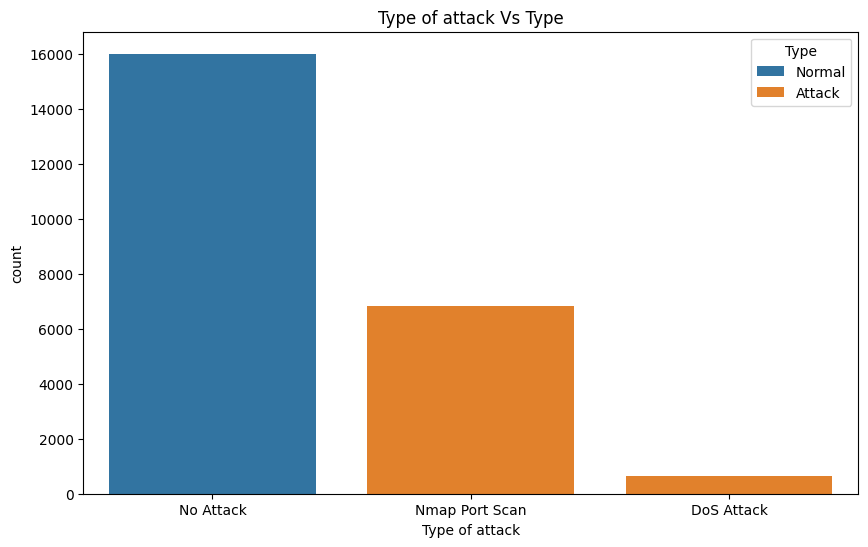

In [17]:
columns_to_plot = [
    'Type of attack', ]

for column in columns_to_plot:
    plt.figure(figsize=(10,6))
    sns.countplot(x=column, hue='Type', data= tcp_df)
    plt.title(f'{column} Vs Type')
    plt.show()

## Drop Redundant Columns
- **Columns Dropped**:
  - `Type of attack`: Redundant due to its equivalence with `Type`.
  - `Protocol`: Single unique value, not useful for analysis.
- **Result**: Data is reduced to the most relevant columns for analysis.

In [18]:
columns_to_drop = ['Type of attack', 'Protocol']
tcp_df = tcp_df.drop(columns= columns_to_drop)
tcp_df.columns

Index(['Source', 'Destination', 'Length', 'Type', 'source_port',
       'destination_port', 'seq', 'length', 'win', 'mss', 'ack', 'tsval',
       'tsecr'],
      dtype='object')

## Encode Target Column
- **Purpose**: Converts the target variable `Type` into numerical format.
  - `Attack`: 1
  - `Normal`: 0
- **Outcome**: Target column (`Type`) is now encoded numerically for machine learning compatibility.

In [19]:
type_encoder = {'Attack': 1, 'Normal': 0}
type_encoder_inverse = {v:k for k, v in type_encoder.items()}
tcp_df['Type'] = tcp_df['Type'].map(type_encoder)

## Verify Remaining Categorical Columns
- **Purpose**: Confirms all columns are now numerical.
- **Output**: No remaining categorical columns, indicating the dataset is fully numeric.

In [20]:
resr_categorical_columns = tcp_df.select_dtypes(include=['object']).columns
print(f"the remaining columns that need to be encoded:\n{resr_categorical_columns.to_list()}")

the remaining columns that need to be encoded:
[]


## Correlation Matrix
- **Purpose**: Visualizes the correlation between numerical columns using a heatmap.
- **Output**: Heatmap showing correlations between columns (provided image).
- **Insights**:
  - Strong correlations:
    - `tsval` and `tsecr` have high positive correlation.
    - `length` shows moderate correlation with `Type`.
  - High correlation might indicate redundancy among features, prompting further investigation.

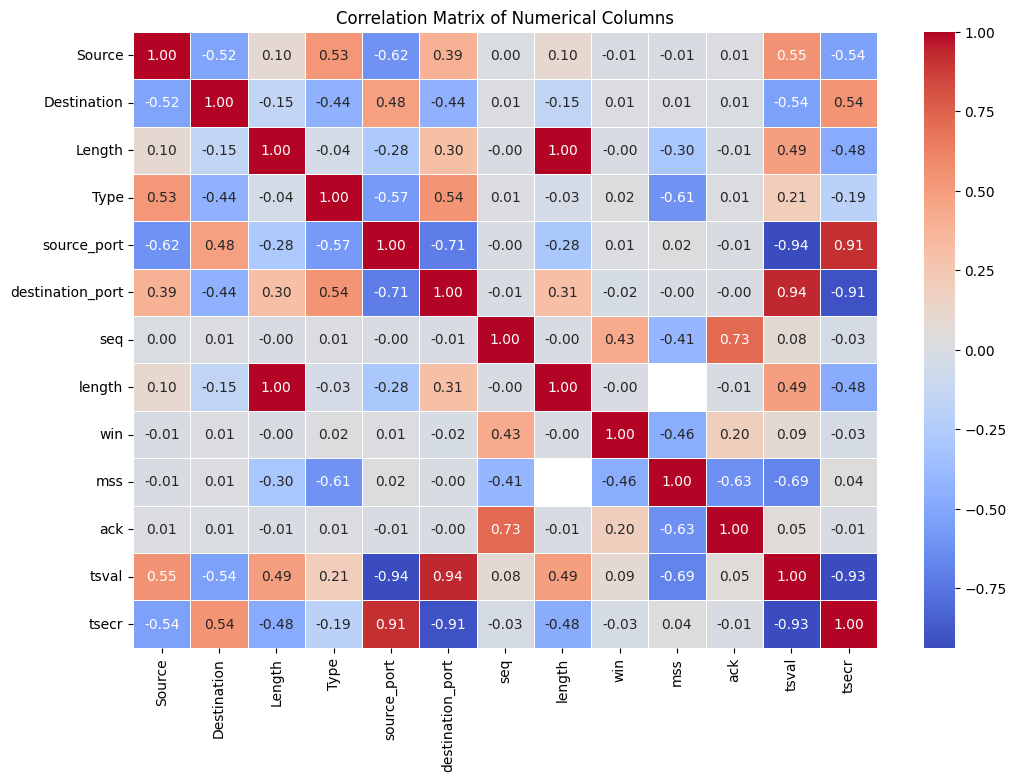

In [21]:

correlation_matrix = tcp_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Matrix of Numerical Columns")
plt.show()

In [22]:
columns_have_a_correlation_with_athers = ['length', 'tsval', 'tsecr']
tcp_df[columns_have_a_correlation_with_athers].isnull().sum()/len(tcp_df) 

length    0.000000
tsval     0.675023
tsecr     0.675023
dtype: float64

In [23]:
tcp_df = tcp_df.drop(columns= columns_have_a_correlation_with_athers[0:])
tcp_df.columns

Index(['Source', 'Destination', 'Length', 'Type', 'source_port',
       'destination_port', 'seq', 'win', 'mss', 'ack'],
      dtype='object')

In [24]:
tcp_df[tcp_df.columns].isnull().sum()/len(tcp_df) 

Source              0.000000
Destination         0.000000
Length              0.000000
Type                0.000000
source_port         0.000000
destination_port    0.000000
seq                 0.000000
win                 0.000000
mss                 0.655359
ack                 0.383843
dtype: float64

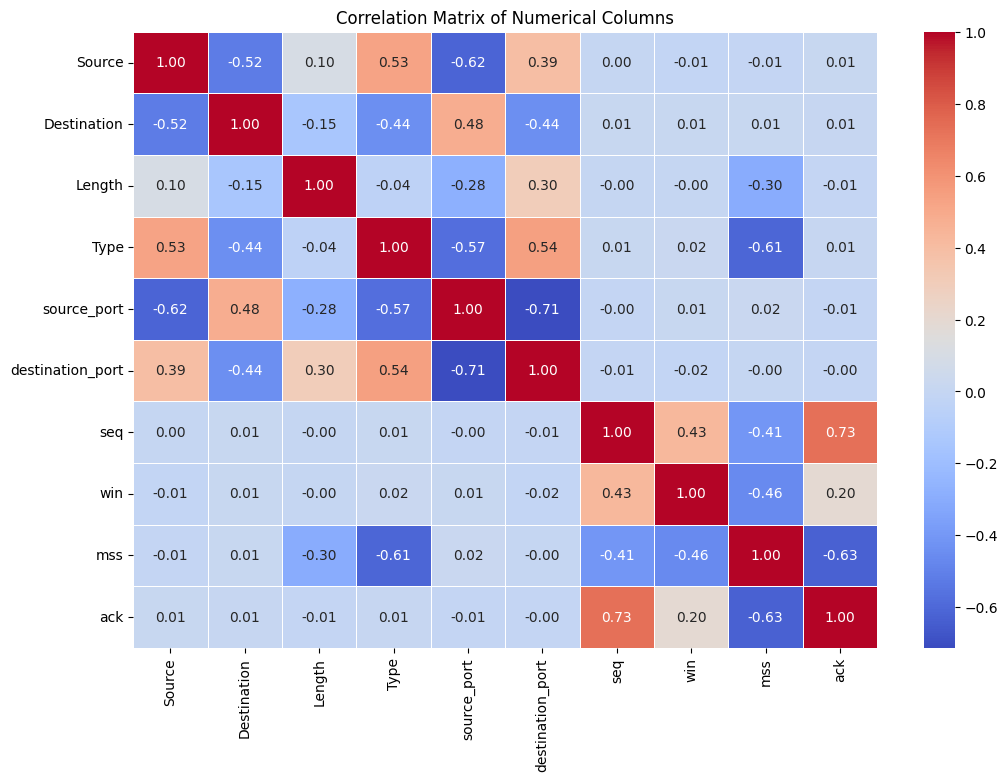

In [25]:
correlation_matrix = tcp_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Matrix of Numerical Columns")
plt.show()

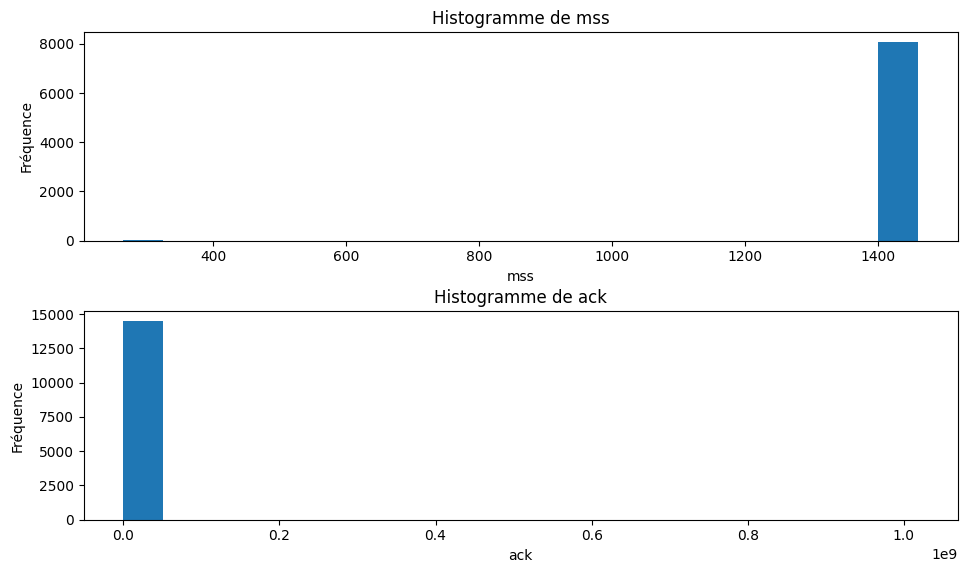

In [26]:
df = tcp_df.copy()  # Ensure tcp_df is defined
numerical_cols = df.select_dtypes(include=np.number).columns
numerical_cols = [col for col in numerical_cols if tcp_df[col].isna().any()]

num_cols = len(numerical_cols)
if num_cols > 0:
    fig, axes = plt.subplots(nrows=num_cols, figsize=(10, 3 * num_cols))
    fig.tight_layout(pad=3.0)

    # Handle cases where only one subplot is created
    if num_cols == 1:
        axes = [axes]

    for i, col in enumerate(numerical_cols):
        ax = axes[i]
        ax.hist(tcp_df[col].dropna(), bins=20)  # Drop NaN values before plotting
        ax.set_title(f'Histogramme de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Fréquence')

    plt.show()
else:
    print("No numerical columns with missing values to plot.")


In [27]:
tcp_df

,Source,Destination,Length,Type,source_port,destination_port,seq,win,mss,ack
6,15,22,58,0,36954,1720,0,1024,1460.0,NaN
7,15,22,58,0,36954,5900,0,1024,1460.0,NaN
8,15,22,58,0,36954,135,0,1024,1460.0,NaN
9,15,22,58,0,36954,143,0,1024,1460.0,NaN
10,15,22,58,0,36954,993,0,1024,1460.0,NaN
...,...,...,...,...,...,...,...,...,...,...
111197,48,0,123,1,3850,443,274,4565,NaN,1.0
111198,48,0,54,0,3850,443,343,4490,NaN,76.0
111199,48,0,395,1,3850,443,343,4490,NaN,76.0
111200,48,0,54,0,3850,443,684,4048,NaN,518.0


In [28]:
method_columns = {
    'median':['mss', 'ack'] 
}
for method, columns in method_columns.items():
    if method == 'median':
        for column in columns:
            tcp_df[column] = tcp_df[column].fillna(tcp_df[column].median())
    elif method == 'mean':
        for column in columns:
            tcp_df[column] = tcp_df[column].fillna(tcp_df[column].mean())

In [29]:
tcp_df.isnull().sum()

Source              0
Destination         0
Length              0
Type                0
source_port         0
destination_port    0
seq                 0
win                 0
mss                 0
ack                 0
dtype: int64

In [30]:
X = tcp_df.drop(columns=['Type'])
labels = tcp_df['Type']
X.shape

(23494, 9)

In [31]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

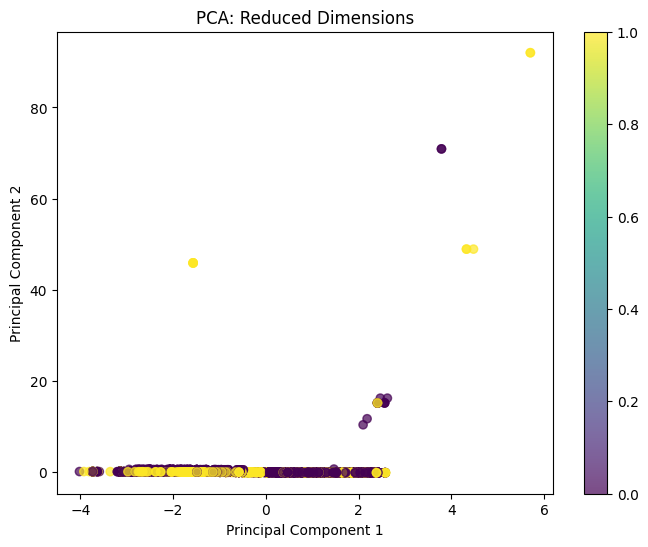

Explained Variance Ratio: [0.30008026 0.22122317 0.12823822 0.1076906  0.06693344 0.06099768
 0.05602992 0.03394416 0.02486255]


In [32]:
pca = PCA()  
X_pca = pca.fit_transform(scaled_data)


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)  # Replace 'labels' with your data labels
plt.title("PCA: Reduced Dimensions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()

# Print explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


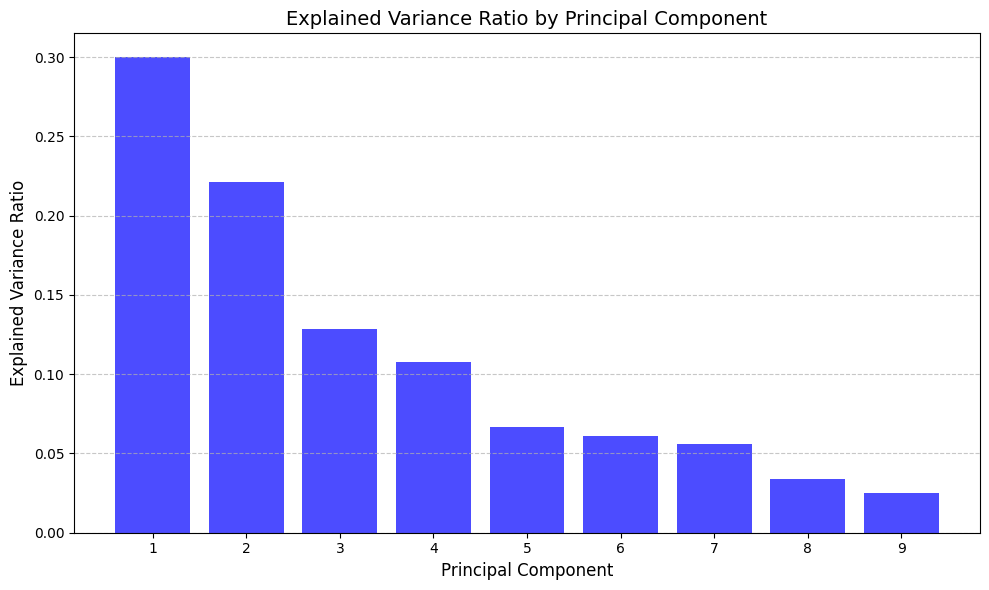

In [33]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, color='b')

# Add labels and title
plt.title("Explained Variance Ratio by Principal Component", fontsize=14)
plt.xlabel("Principal Component", fontsize=12)
plt.ylabel("Explained Variance Ratio", fontsize=12)
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))  # Label each component
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

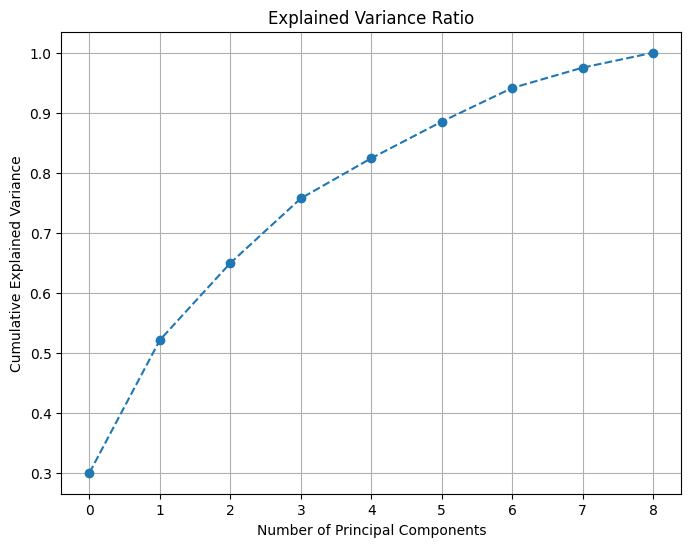

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.grid()
plt.show()

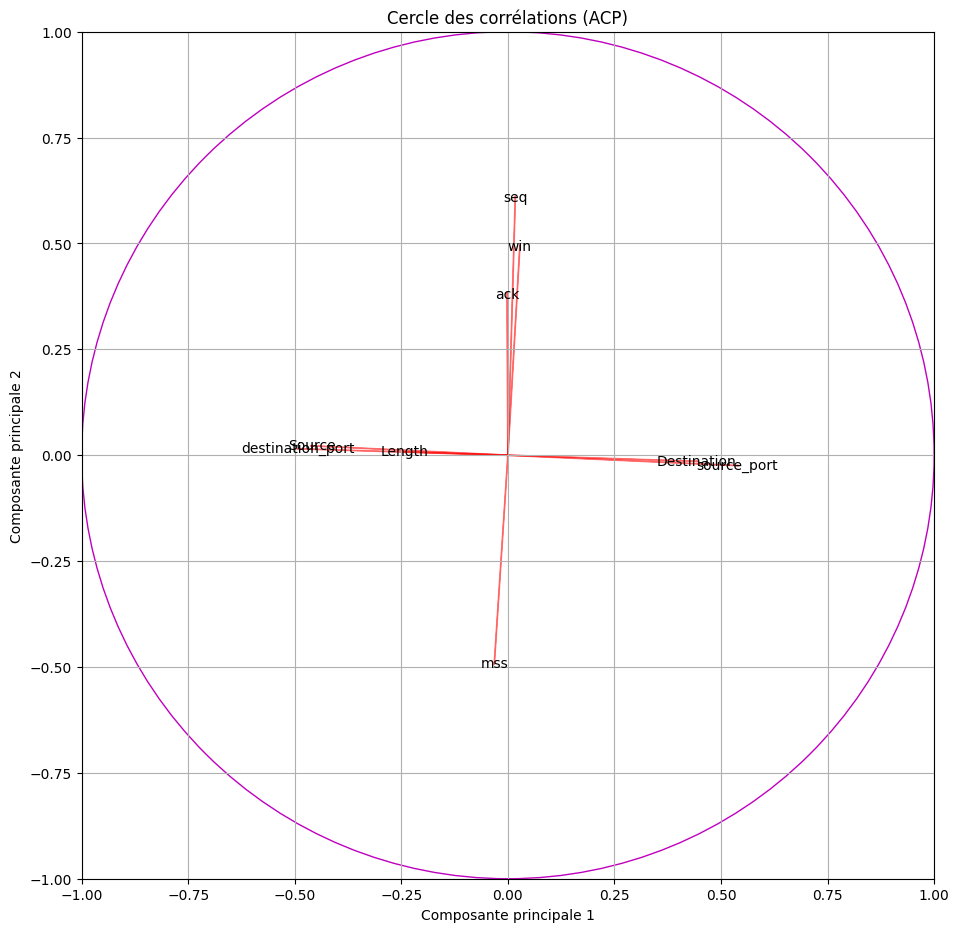

In [35]:
# Affichage du cercle des corrélations
fig, axes = plt.subplots(figsize=(11, 11))
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

# Cercle unité
circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='m')
axes.add_artist(circle)

# Afficher les coordonnées des variables sur le cercle des corrélations
for i, variable in enumerate(X.columns):
    x = pca.components_[0, i]
    y = pca.components_[1, i]
    plt.arrow(0, 0, x, y, color='r', alpha=0.5)
    plt.text(x, y, variable,  ha='center', va='center')

plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Cercle des corrélations (ACP)")
plt.grid(True)
plt.show()

___
             Split, Balance, and Normalize the data                 
---          

In [36]:
X = tcp_df.drop(columns=['Type'])
y = tcp_df['Type']

In [37]:
# Step 1: Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
# Step 2: Balance the data using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [39]:
y_train_balanced.value_counts(), y_train.value_counts()

(Type
 0    12821
 1    12821
 Name: count, dtype: int64,
 Type
 0    12821
 1     5974
 Name: count, dtype: int64)

In [40]:
# Step 3: Normalize the data using StandardScaler
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_balanced)
X_test_normalized = scaler.transform(X_test)

___
                        Train Models                    
---

In [54]:
# Random Forest Classifier with important hyperparameters
rf = RandomForestClassifier(
    n_estimators=50,           # Number of trees in the forest
    max_depth=10,              # Maximum depth of each tree
    # min_samples_split=2,       # Minimum samples required to split an internal node
    # min_samples_leaf=1,        # Minimum samples required to be at a leaf node
    # max_features='sqrt',       # Number of features to consider when looking for the best split
    random_state=42            # For reproducibility
)

# AdaBoost Classifier with important hyperparameters
adab = AdaBoostClassifier(
    n_estimators=50,           # Number of weak learners
    learning_rate=1.0,         # Shrinks the contribution of each weak learner
    random_state=42            # For reproducibility
)

# Gradient Boosting Classifier with important hyperparameters
gbm = GradientBoostingClassifier(
    n_estimators=50,          # Number of boosting stages
    learning_rate=0.1,         # Learning rate
    max_depth=10,               # Maximum depth of individual trees
    # min_samples_split=2,       # Minimum samples required to split an internal node
    # min_samples_leaf=1,        # Minimum samples required to be at a leaf node
    random_state=42            # For reproducibility
)

# XGBoost Classifier with important hyperparameters
model = XGBClassifier(
    n_estimators=50,          # Number of trees
    learning_rate=0.1,         # Step size shrinkage used to prevent overfitting
    max_depth=10,               # Maximum depth of each tree
    # subsample=0.8,             # Subsample ratio of the training instance
    # colsample_bytree=0.8,      # Subsample ratio of columns when constructing each tree
    random_state=42            # For reproducibility
)

# Gaussian Naive Bayes with important hyperparameters
GNB = GaussianNB(
    var_smoothing=1e-9         # Portion of the largest variance added to variances for stability
)

# Decision Tree Classifier with important hyperparameters
dt = DecisionTreeClassifier(
    max_depth=50,            # Maximum depth of the tree
    # min_samples_split=2,       # Minimum samples required to split an internal node
    # min_samples_leaf=1,        # Minimum samples required to be at a leaf node
    # max_features=None,         # Number of features to consider when looking for the best split
    random_state=42            # For reproducibility
)


estimators = [rf, adab, gbm, model, GNB, dt]
classifiers = ['RandomForestClassifier', 'AdaBoostClassifier', 
                'GradientBoostingClassifier', 'XGBoostClassifier',
                 'Gaussian Naive Bayes Classifier', 'DecisionTreeClassifier']


In [55]:
X_train, X_test, y_train = X_train_normalized, X_test_normalized, y_train_balanced

In [56]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25642, 9), (4699, 9), (25642,), (4699,))

In [67]:
# Train each model
for name, estimator in zip(classifiers, estimators):
    print("-"*50)
    print(f"Training {name}...")
    estimator.fit(X_train, y_train)
    print(f"{name} training complete.")


--------------------------------------------------
Training RandomForestClassifier...
RandomForestClassifier training complete.
--------------------------------------------------
Training AdaBoostClassifier...
AdaBoostClassifier training complete.
--------------------------------------------------
Training GradientBoostingClassifier...
GradientBoostingClassifier training complete.
--------------------------------------------------
Training XGBoostClassifier...
XGBoostClassifier training complete.
--------------------------------------------------
Training Gaussian Naive Bayes Classifier...
Gaussian Naive Bayes Classifier training complete.
--------------------------------------------------
Training DecisionTreeClassifier...
DecisionTreeClassifier training complete.


                             Model  Accuracy  Precision    Recall  F1 Score  \
0           RandomForestClassifier  0.971696   0.981013  0.929380  0.954499   
1               AdaBoostClassifier  0.955735   0.933602  0.927382  0.930481   
2       GradientBoostingClassifier  0.968930   0.964997  0.936709  0.950642   
3                XGBoostClassifier  0.970206   0.976875  0.928714  0.952186   
4  Gaussian Naive Bayes Classifier  0.828687   0.800518  0.617588  0.697255   
5           DecisionTreeClassifier  0.960630   0.939840  0.936709  0.938272   

        AUC  
0  0.994254  
1  0.991296  
2  0.993191  
3  0.994120  
4  0.910830  
5  0.956425  


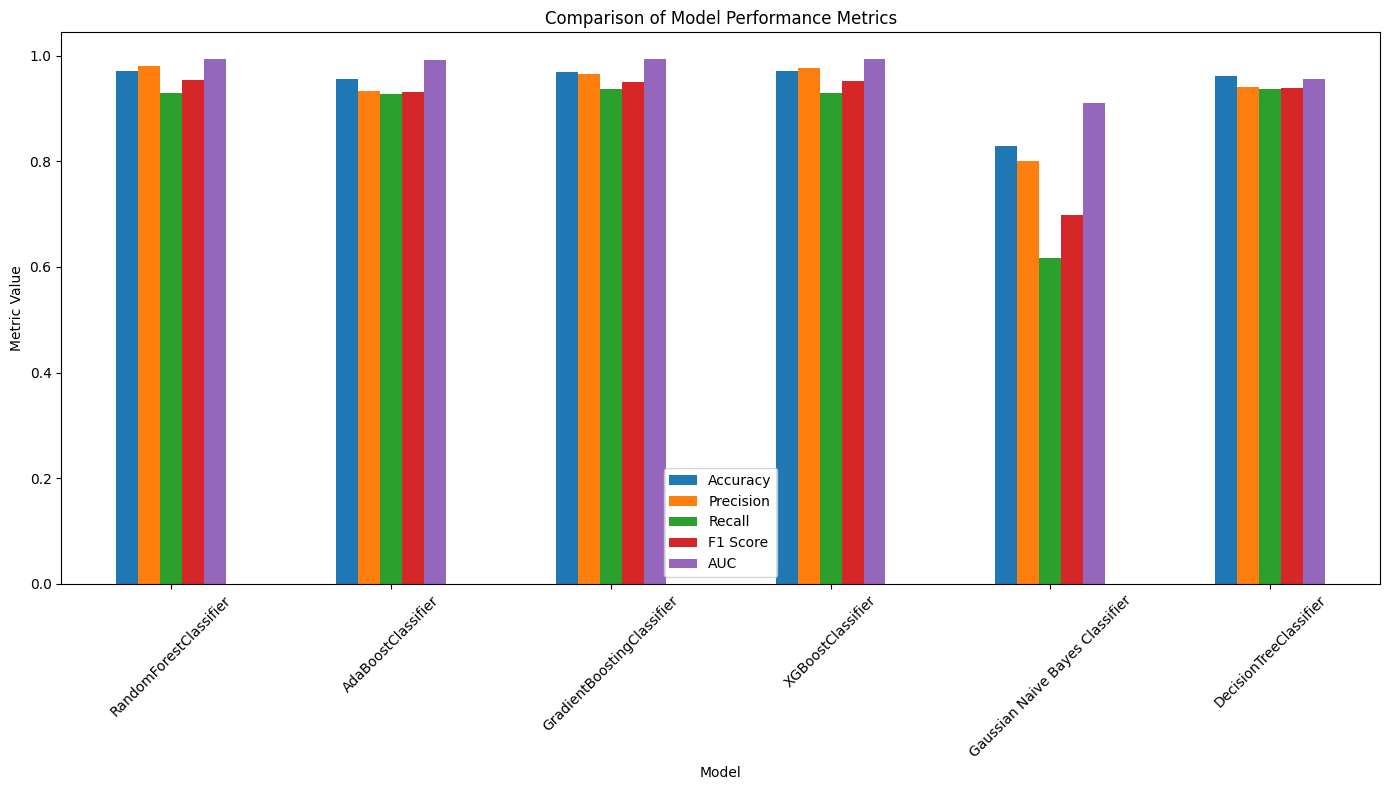

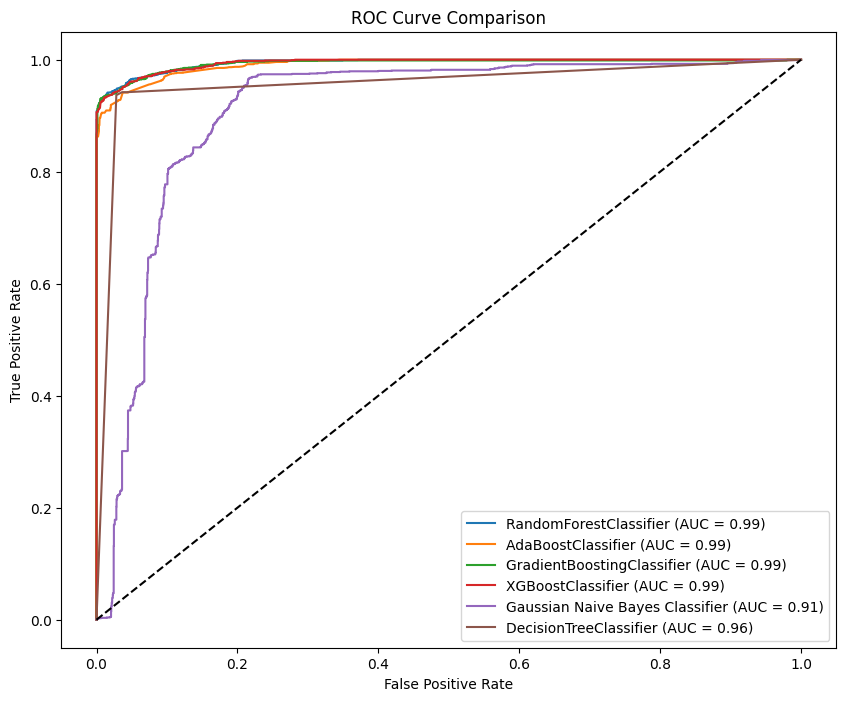

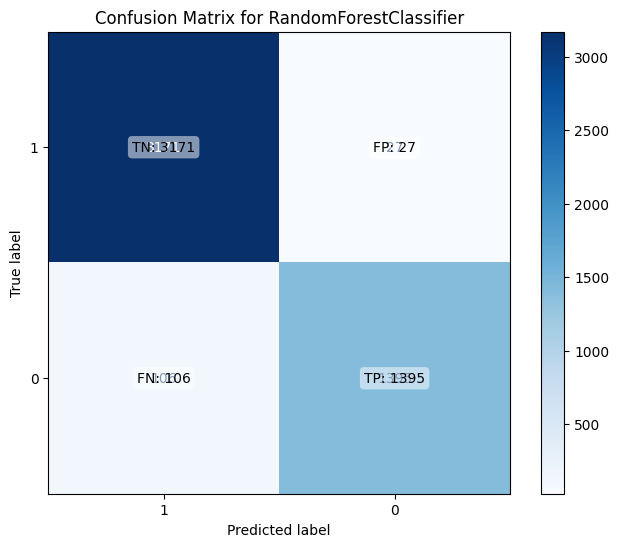

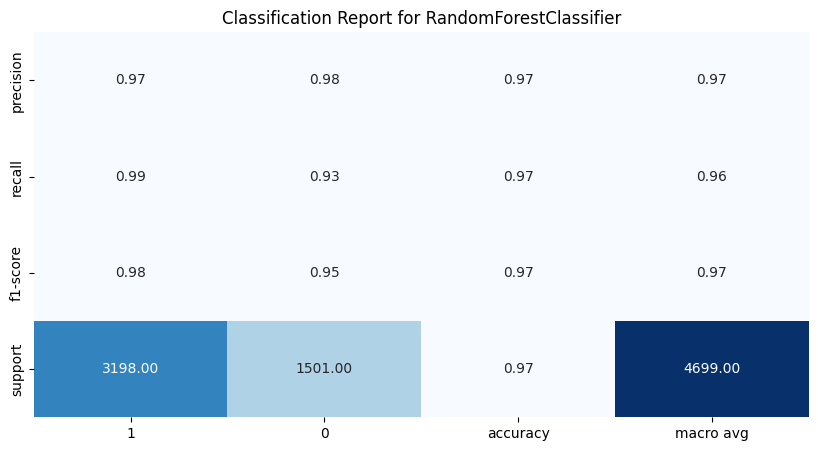

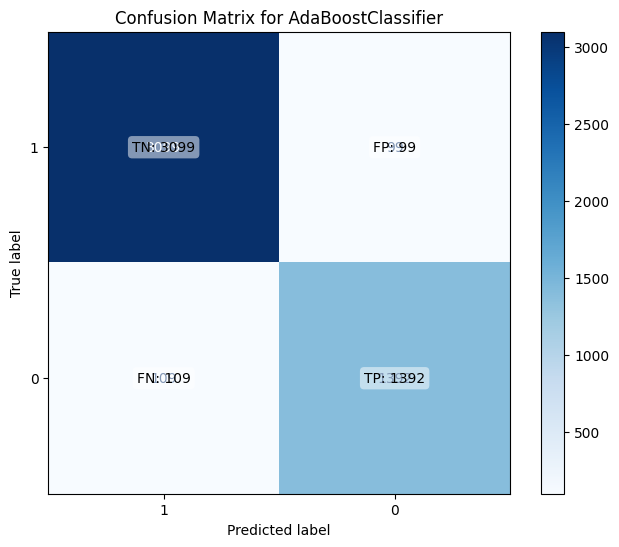

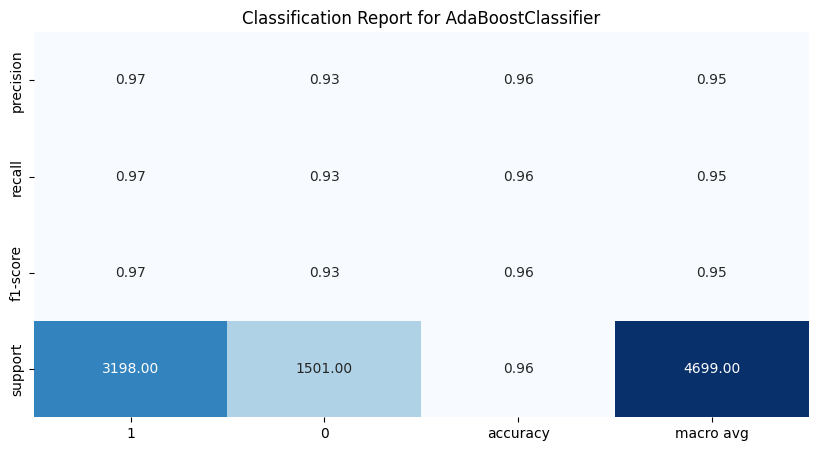

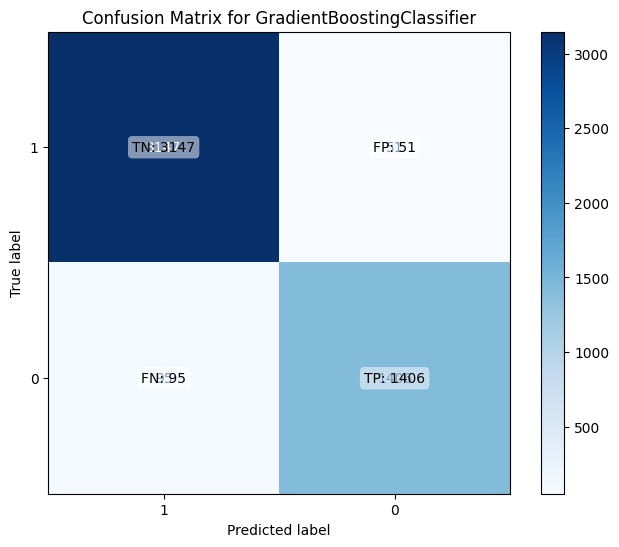

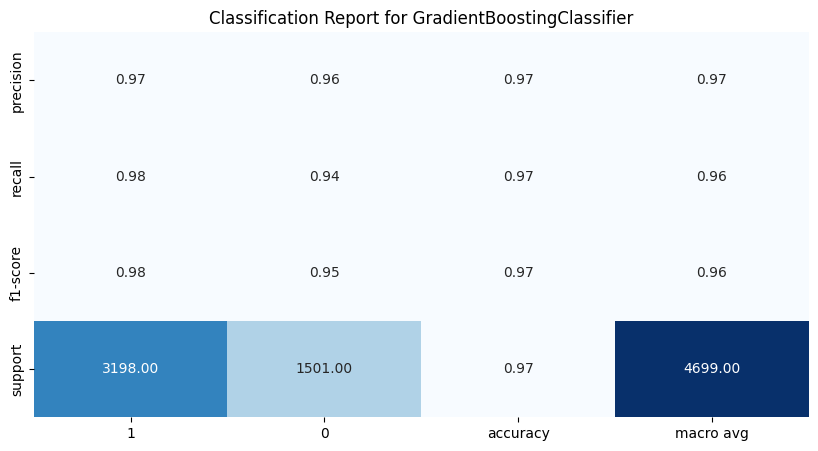

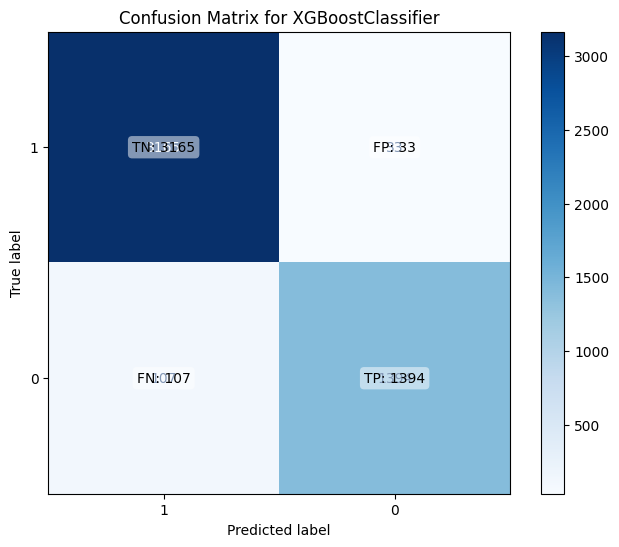

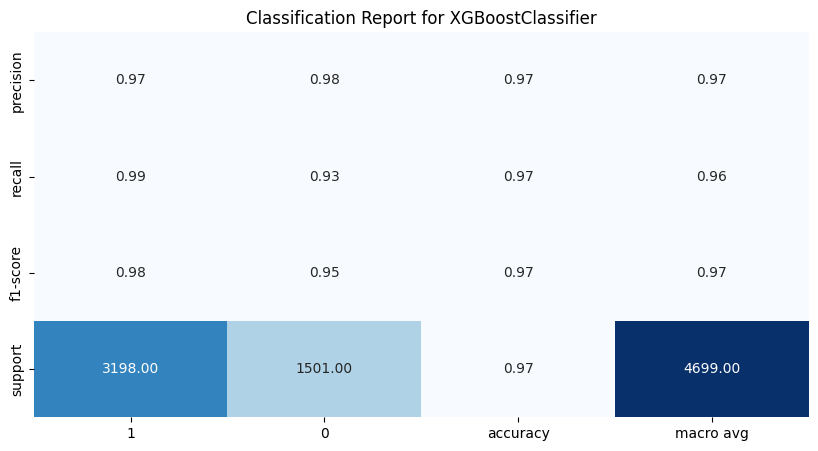

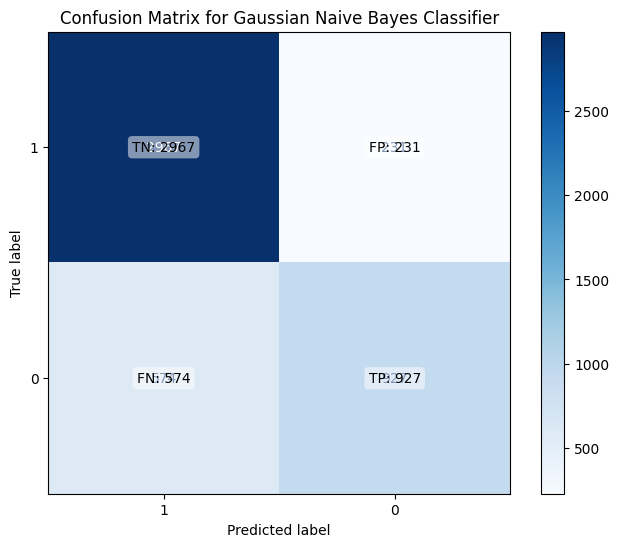

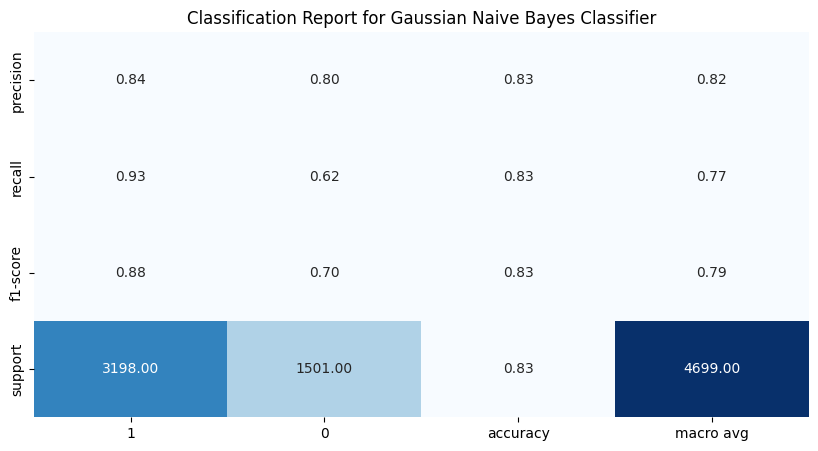

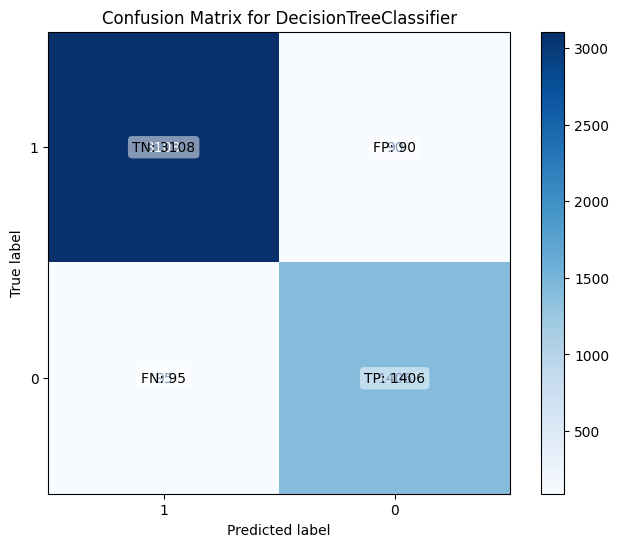

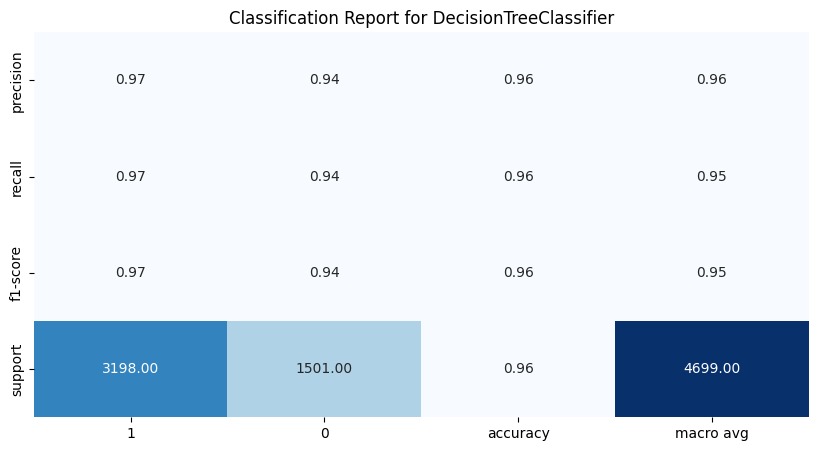

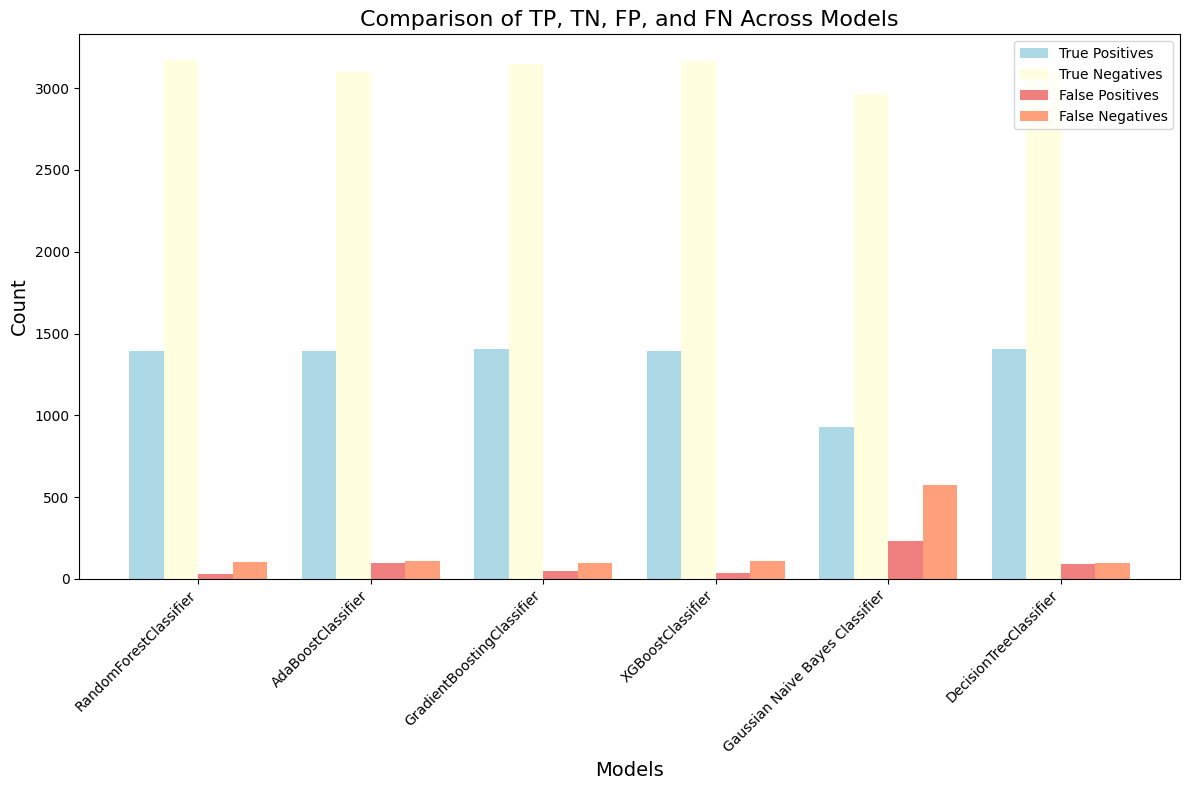

In [58]:
evaluate_models(estimators, classifiers, type_encoder_inverse, X_test, y_test)

----
                            with PCA                               
---

Explained variance ratio: 52.13%
[0.30008026 0.22122317]


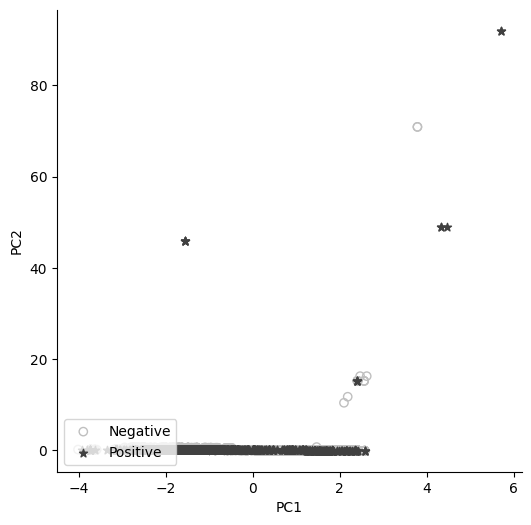

In [59]:
def plot_2d(X, y, title=''):
    from sklearn.preprocessing import StandardScaler
    X_std = StandardScaler().fit_transform(X)

    from sklearn.decomposition import PCA
    dec = PCA(n_components=2)
    X_reduced = dec.fit_transform(X_std)
    
    f, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X_reduced[y==0,0], X_reduced[y==0,1], 
               facecolors='none', edgecolors='0.75', label="Negative")
    ax.scatter(X_reduced[y==1,0], X_reduced[y==1,1], c='0.25', marker='*', 
               label='Positive')
    ax.legend(loc='lower left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    print ("Explained variance ratio: %.2f%%" % 
           (100*dec.explained_variance_ratio_.sum()))
    print (dec.explained_variance_ratio_)
    #plt.savefig('img/plot2d.jpeg',format='jpeg',bbox_inches='tight',dpi=450)
    plt.show()
    

X = tcp_df.drop(columns=['Type'])
labels = tcp_df['Type']

plot_2d(X, labels)

In [60]:
# Apply PCA with 95% explained variance
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)  # Transform the data
X_test_pca = pca.transform(X_test)

# Check the number of components selected
print(f"Number of components selected to retain 95% variance: {pca.n_components_}")


Number of components selected to retain 95% variance: 7


In [61]:
X_train_pca.shape, X_train.shape, X_test_pca.shape, X_test.shape

((25642, 7), (25642, 9), (4699, 7), (4699, 9))

In [62]:
# Random Forest Classifier with important hyperparameters
rf_pca = RandomForestClassifier(
    n_estimators=50,           # Number of trees in the forest
    max_depth=10,              # Maximum depth of each tree
    random_state=42            # For reproducibility
)

# AdaBoost Classifier with important hyperparameters
adab_pca = AdaBoostClassifier(
    n_estimators=50,           # Number of weak learners
    learning_rate=1.0,         # Shrinks the contribution of each weak learner
    random_state=42            # For reproducibility
)

# Gradient Boosting Classifier with important hyperparameters
gbm_pca = GradientBoostingClassifier(
    n_estimators=50,          # Number of boosting stages
    learning_rate=0.1,         # Learning rate
    max_depth=10,               # Maximum depth of individual trees
    random_state=42            # For reproducibility
)

# XGBoost Classifier with important hyperparameters
model_pca = XGBClassifier(
    n_estimators=50,          # Number of trees
    learning_rate=0.1,         # Step size shrinkage used to prevent overfitting
    max_depth=10,               # Maximum depth of each tree
    random_state=42            # For reproducibility
)

# Gaussian Naive Bayes with important hyperparameters
GNB_pca = GaussianNB(
    var_smoothing=1e-9         # Portion of the largest variance added to variances for stability
)

# Decision Tree Classifier with important hyperparameters
dt_pca = DecisionTreeClassifier(
    max_depth=50,            # Maximum depth of the tree
    random_state=42            # For reproducibility
)


estimators_pca = [rf_pca, adab_pca, gbm_pca, model_pca, GNB_pca, dt_pca]
classifiers_pca = ['RandomForestClassifier_pca', 'AdaBoostClassifier_pca', 
                'GradientBoostingClassifier_pca', 'XGBoostClassifier_pca',
                 'Gaussian Naive Bayes Classifier_pca', 'DecisionTreeClassifier_pca']


In [65]:
# Train each model
for name, estimator in zip(classifiers_pca, estimators_pca):
    print("-"*50)
    print(f"Training {name}...")
    estimator.fit(X_train_pca, y_train)
    print(f"{name} training complete.")

--------------------------------------------------
Training RandomForestClassifier_pca...
RandomForestClassifier_pca training complete.
--------------------------------------------------
Training AdaBoostClassifier_pca...
AdaBoostClassifier_pca training complete.
--------------------------------------------------
Training GradientBoostingClassifier_pca...
GradientBoostingClassifier_pca training complete.
--------------------------------------------------
Training XGBoostClassifier_pca...
XGBoostClassifier_pca training complete.
--------------------------------------------------
Training Gaussian Naive Bayes Classifier_pca...
Gaussian Naive Bayes Classifier_pca training complete.
--------------------------------------------------
Training DecisionTreeClassifier_pca...
DecisionTreeClassifier_pca training complete.


                                 Model  Accuracy  Precision    Recall  \
0           RandomForestClassifier_pca  0.959779   0.950549  0.922052   
1               AdaBoostClassifier_pca  0.920834   0.857958  0.901399   
2       GradientBoostingClassifier_pca  0.961694   0.950239  0.928714   
3                XGBoostClassifier_pca  0.957863   0.942896  0.924051   
4  Gaussian Naive Bayes Classifier_pca  0.858693   0.734454  0.873418   
5           DecisionTreeClassifier_pca  0.955948   0.932487  0.929380   

   F1 Score       AUC  
0  0.936084  0.988902  
1  0.879142  0.976839  
2  0.939353  0.990254  
3  0.933378  0.989330  
4  0.797931  0.892739  
5  0.930931  0.949624  


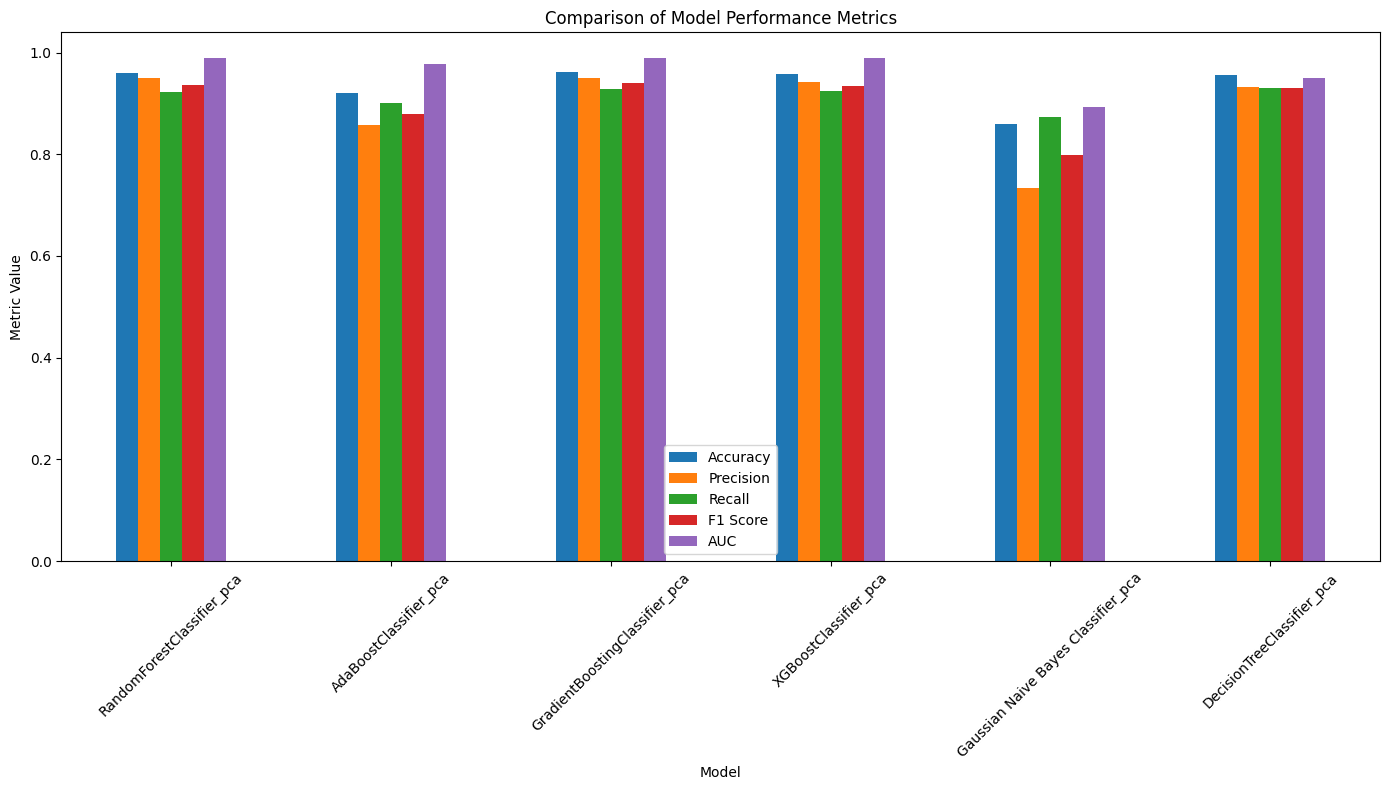

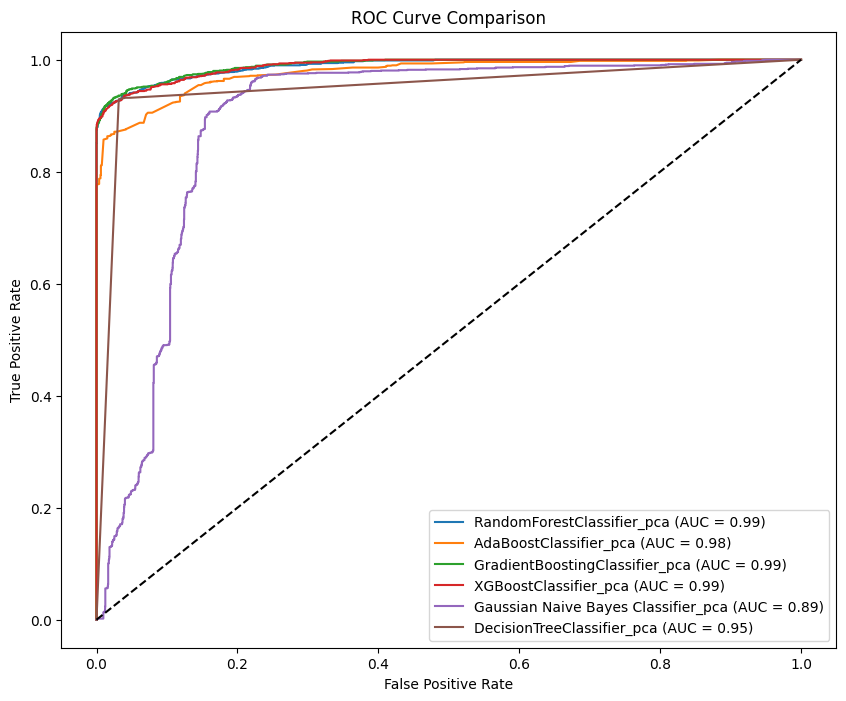

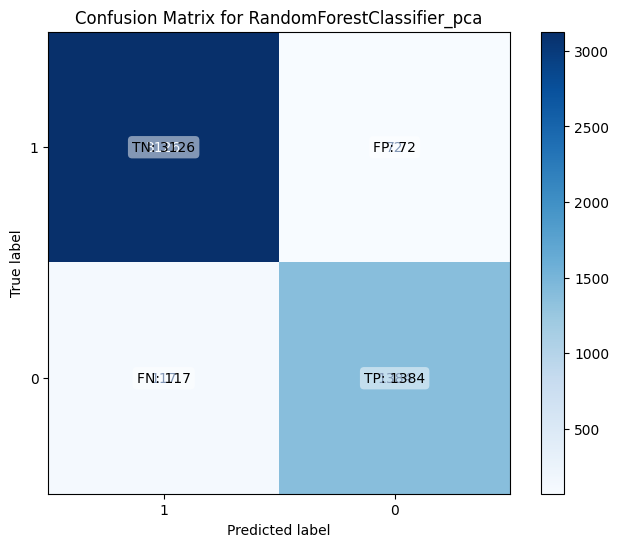

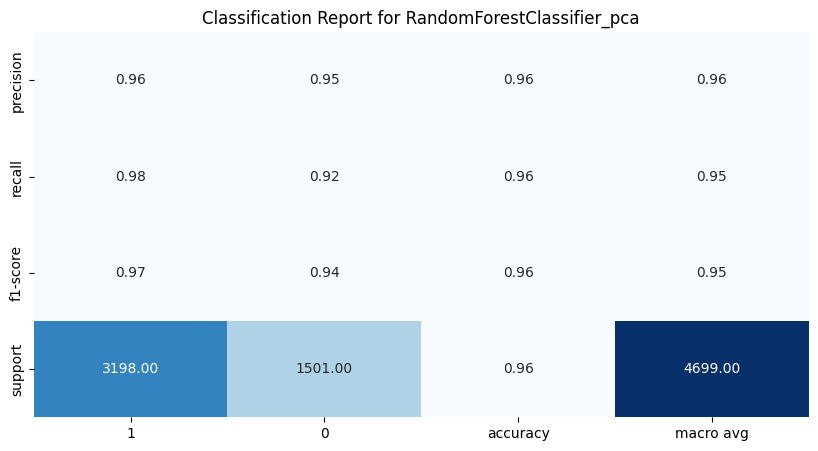

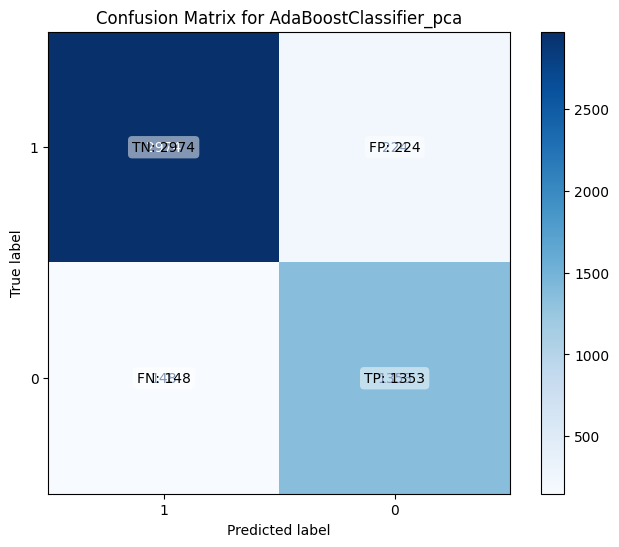

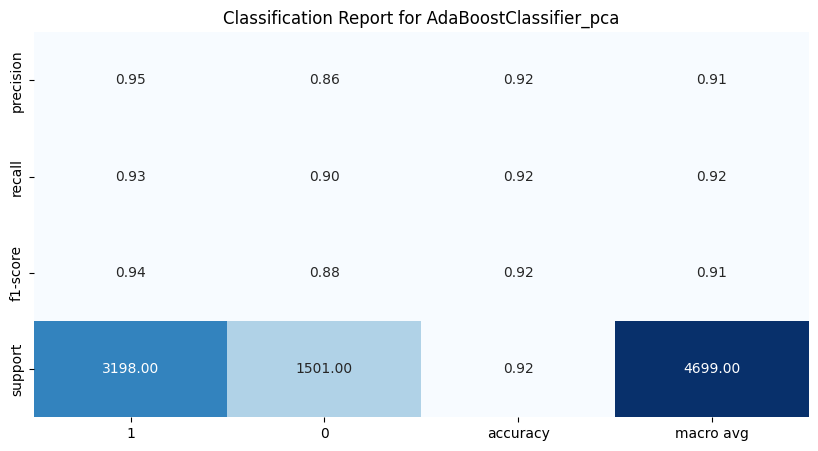

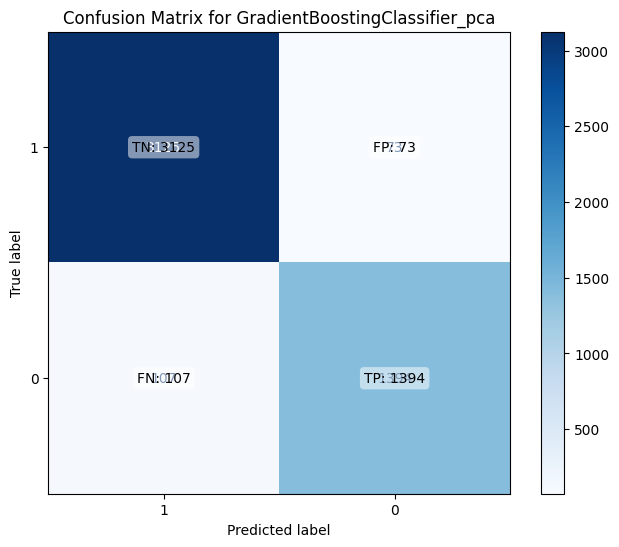

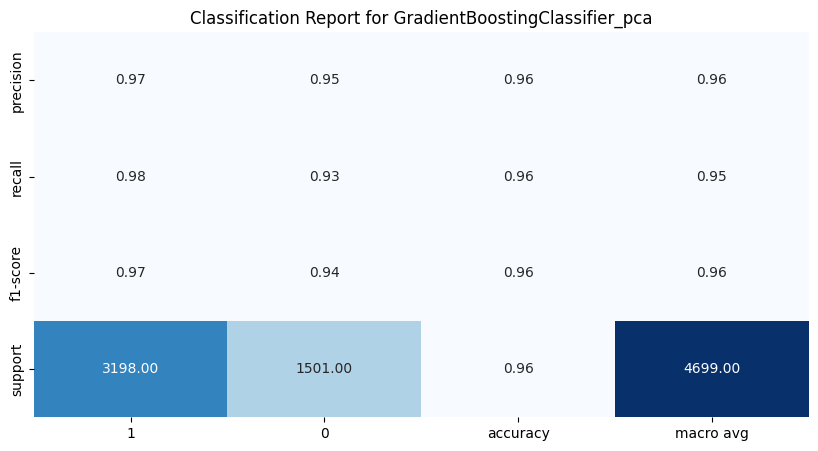

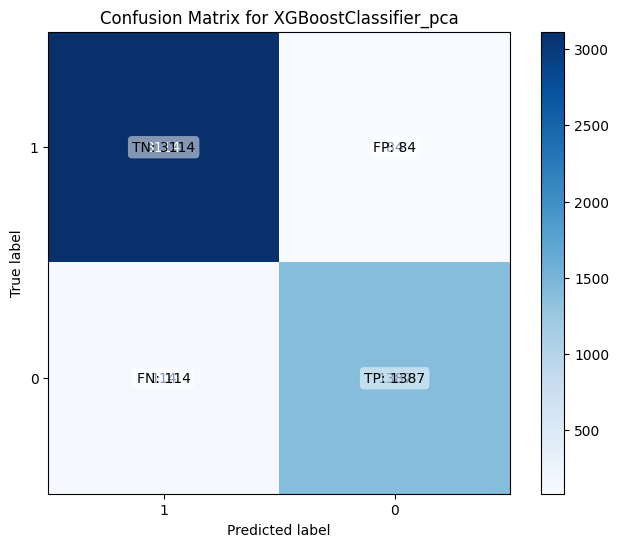

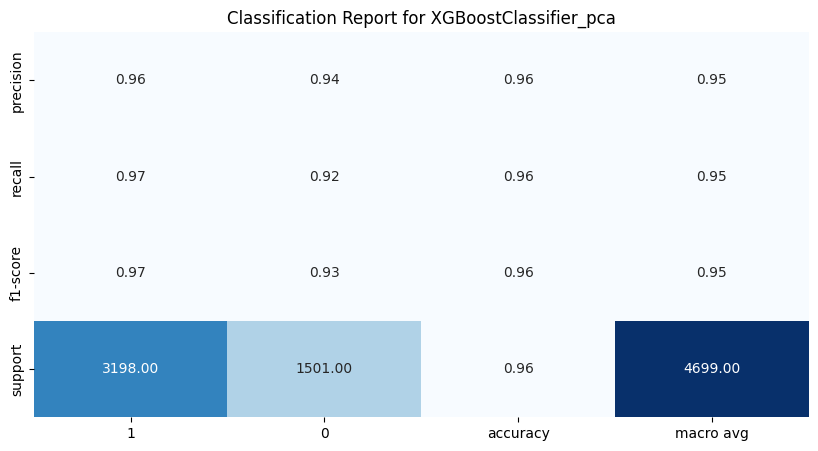

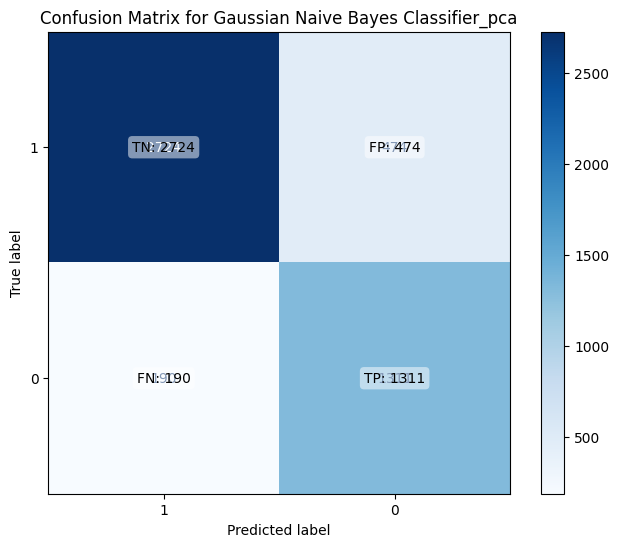

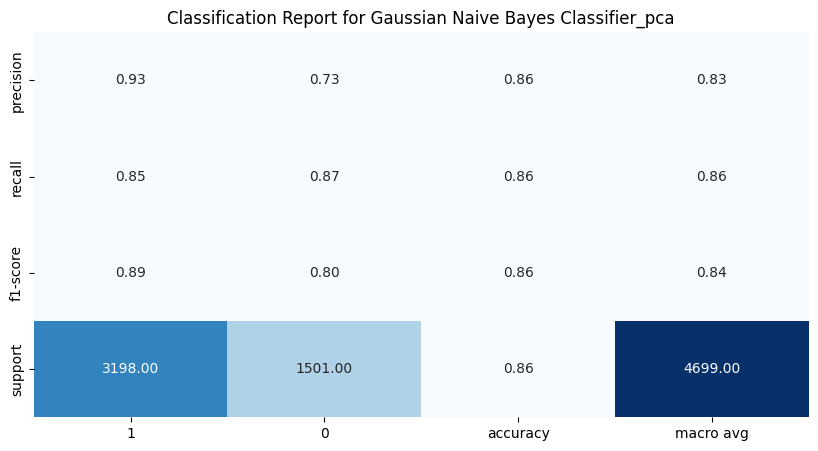

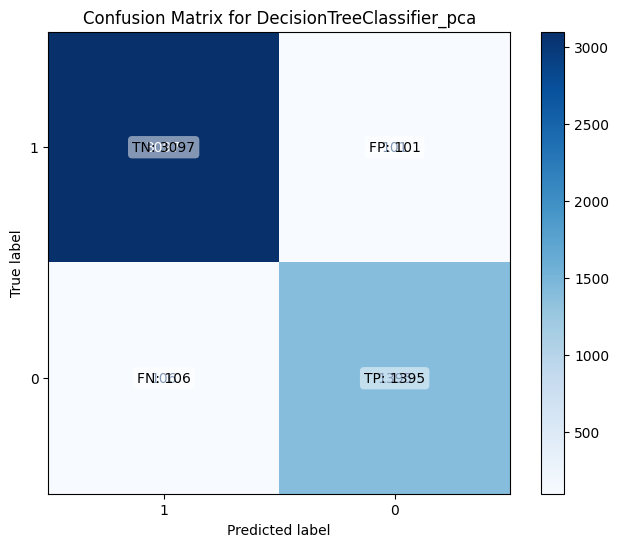

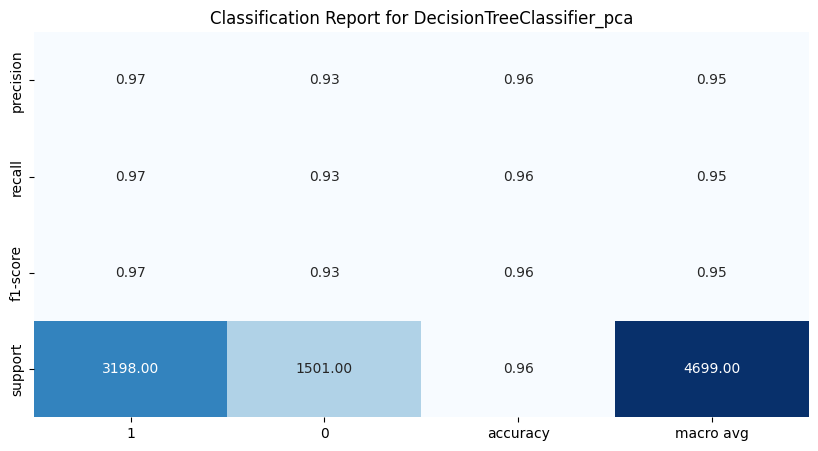

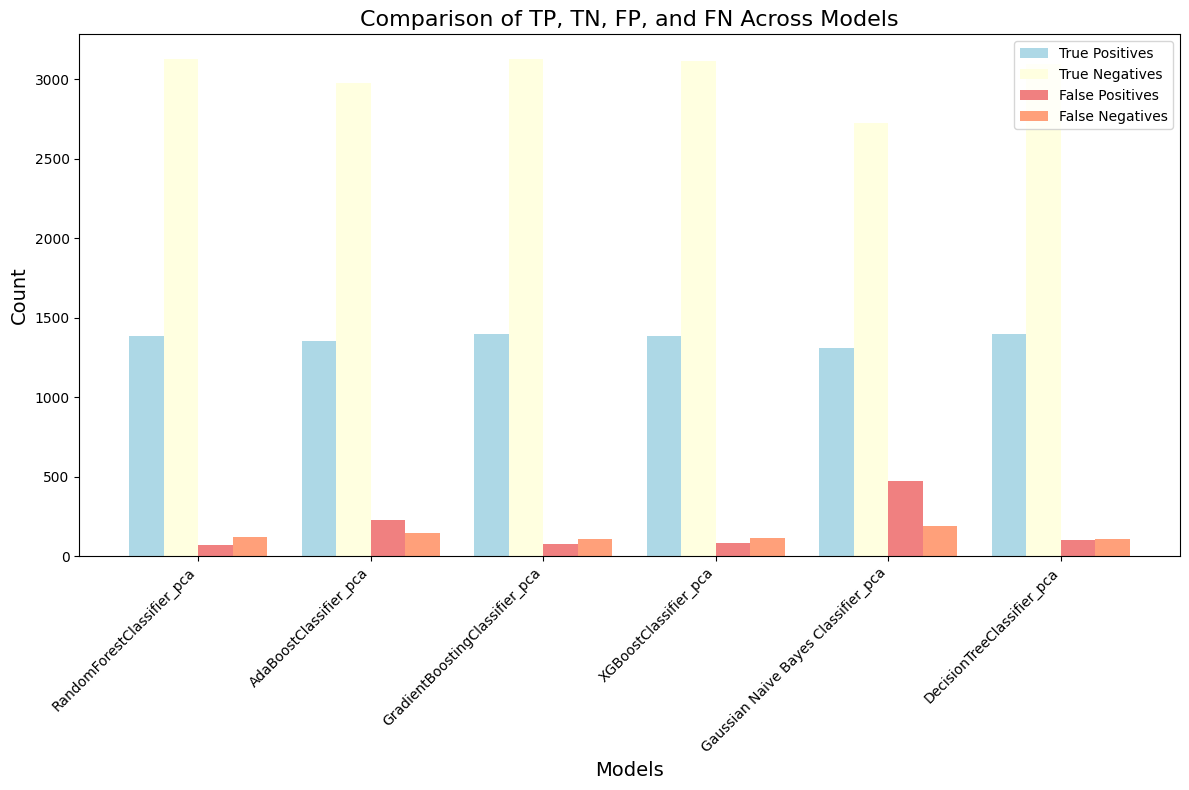

In [66]:
evaluate_models(estimators_pca, classifiers_pca, type_encoder_inverse, X_test_pca, y_test)

---
            Comparison of estimators with and without PCA                  
---

In [68]:
all_estimators = estimators_pca + estimators
all_classifiers = classifiers_pca + classifiers

In [75]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
metrics_list = []

# Loop over models to calculate and store metrics
for i, estimator in enumerate(all_estimators):
    # Make predictions on the test set
    try:
        y_pred = estimator.predict(X_test)
        y_pred_prob = estimator.predict_proba(X_test)[:, 1]  # Probabilities for ROC Curve
    except:
        y_pred = estimator.predict(X_test_pca)
        y_pred_prob = estimator.predict_proba(X_test_pca)[:, 1] 
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Extract TN, FP, FN, TP
    tn, fp, fn, tp = cm.ravel()
    
    # Compute metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Compute ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Append metrics to the list
    metrics_list.append({
        'Model': all_classifiers[i],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'AUC': roc_auc
    })

# Convert the list of metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_list)

In [77]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,RandomForestClassifier_pca,0.959779,0.950549,0.922052,0.936084,0.988902
1,AdaBoostClassifier_pca,0.920834,0.857958,0.901399,0.879142,0.976839
2,GradientBoostingClassifier_pca,0.961694,0.950239,0.928714,0.939353,0.990254
3,XGBoostClassifier_pca,0.957863,0.942896,0.924051,0.933378,0.989330
4,Gaussian Naive Bayes Classifier_pca,0.858693,0.734454,0.873418,0.797931,0.892739
5,DecisionTreeClassifier_pca,0.955948,0.932487,0.929380,0.930931,0.949624
6,RandomForestClassifier,0.971696,0.981013,0.929380,0.954499,0.994254
7,AdaBoostClassifier,0.955735,0.933602,0.927382,0.930481,0.991296
8,GradientBoostingClassifier,0.968930,0.964997,0.936709,0.950642,0.993191
9,XGBoostClassifier,0.970206,0.976875,0.928714,0.952186,0.994120


In [ ]:
metrics_df.to_csv("results/over_sampling_results.csv")

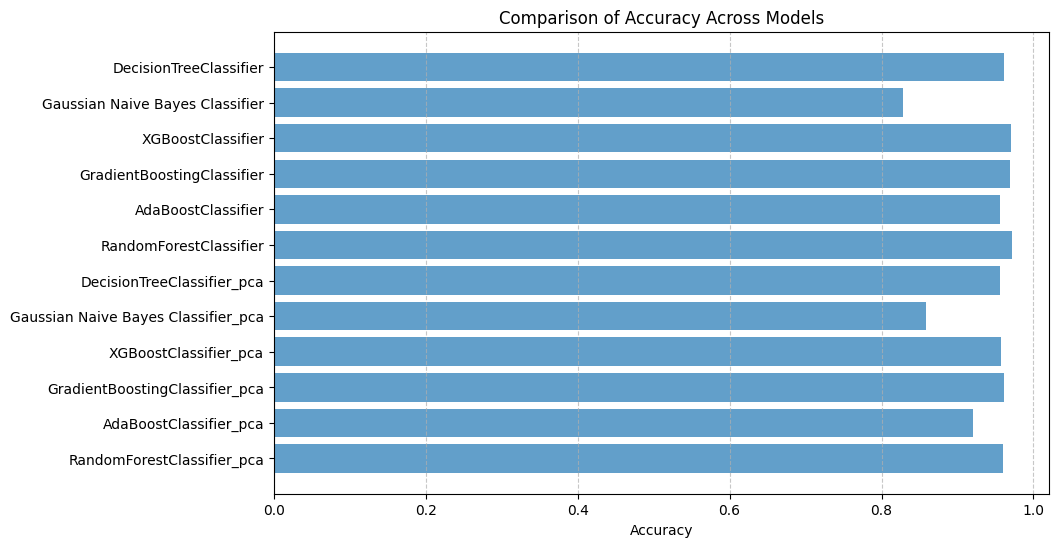

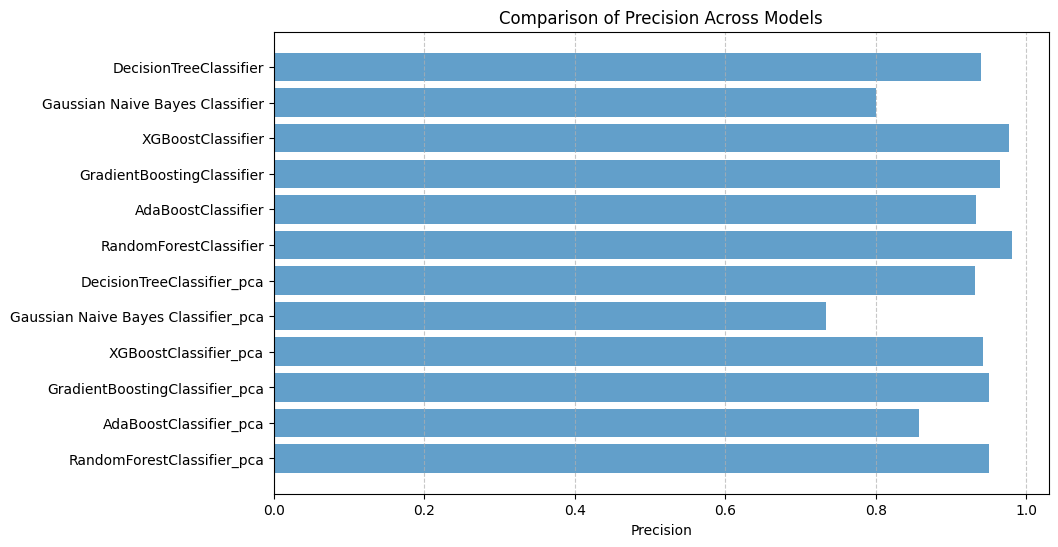

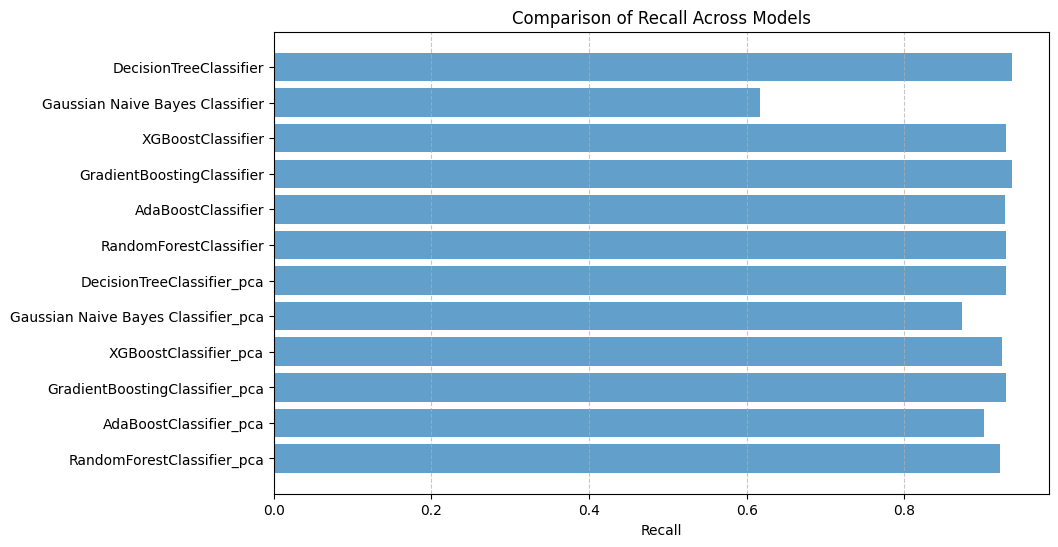

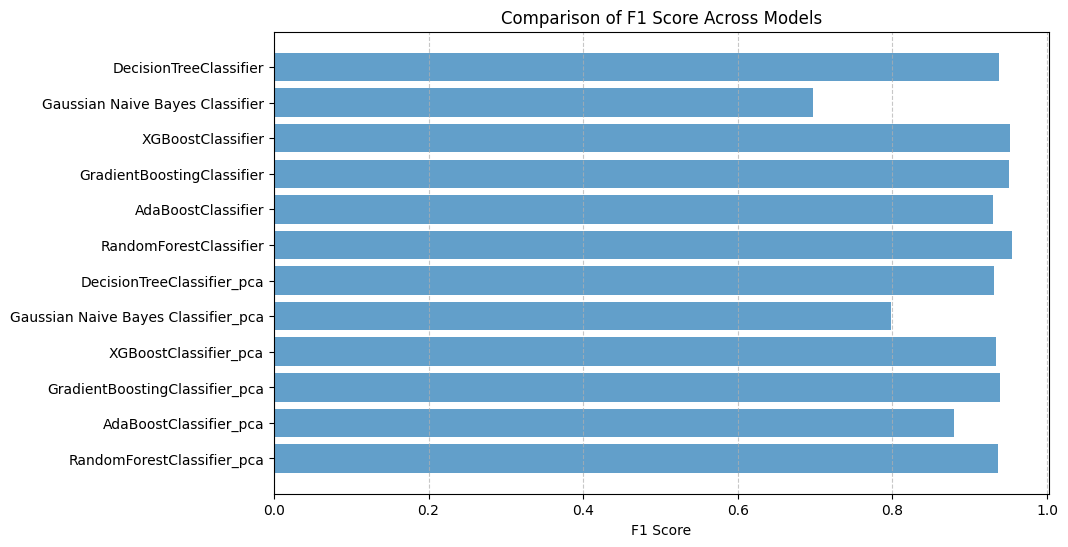

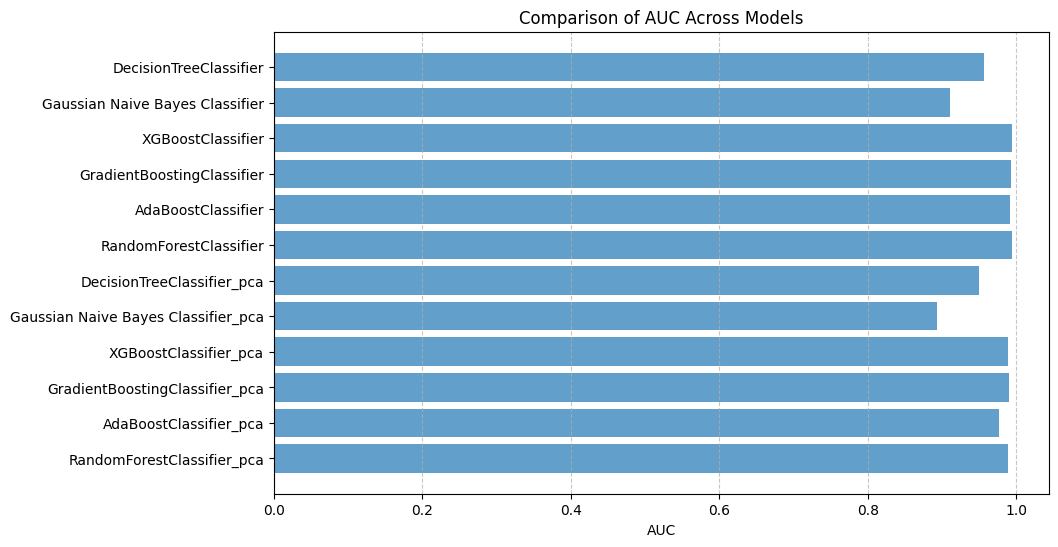

In [78]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.barh(metrics_df['Model'], metrics_df[metric], alpha=0.7)
    plt.xlabel(metric)
    plt.title(f'Comparison of {metric} Across Models')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

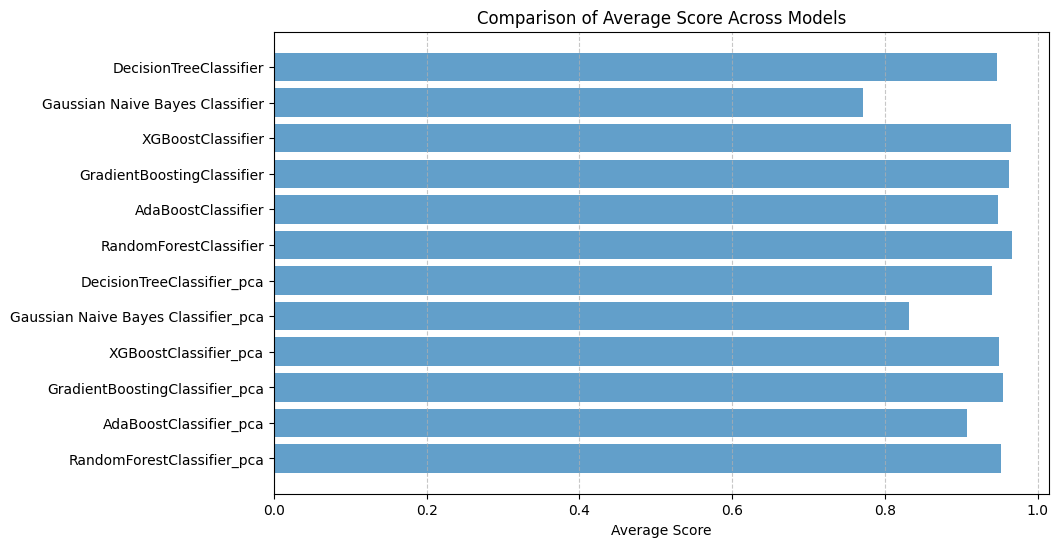

In [81]:
# Calculate the average score for each classifier across all metrics
metrics_df['Average Score'] = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']].mean(axis=1)
metrics = ['Average Score']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.barh(metrics_df['Model'], metrics_df[metric], alpha=0.7)
    plt.xlabel(metric)
    plt.title(f'Comparison of {metric} Across Models')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

In [82]:
# Find the classifier with the highest average score
best_classifier = metrics_df.loc[metrics_df['Average Score'].idxmax()]

best_classifier

Model            RandomForestClassifier
Accuracy                       0.971696
Precision                      0.981013
Recall                          0.92938
F1 Score                       0.954499
AUC                            0.994254
Average Score                  0.966168
Name: 6, dtype: object

In [89]:
best_model = all_estimators[metrics_df['Average Score'].idxmax()]
best_model

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

In [ ]:
import pickle
with open('best_classifier.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print('Best classifier saved as best_classifier_for_tcp_protocol.pkl')

Best classifier saved as best_classifier_for_tcp_protocol.pkl


---
            Use cross-validation with RandomForestClassifier              
---

In [92]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees
    'max_depth': [10, 20, 30],         # Maximum depth of each tree
    'max_features': ['sqrt', 'log2'],        # Number of features to consider for the best split
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Evaluation metric
    verbose=2,                # Print progress
    n_jobs=-1                 # Use all available CPU cores
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Display the best parameters and the corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Best Accuracy: 0.9678657409505582


In [95]:
best_classifier['Accuracy'] < grid_search.best_score_

np.False_